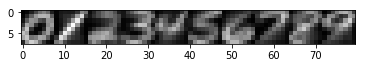

In [2]:
'''
Question 2.0 Skeleton Code

Here you should load the data and plot
the means for each of the digit classes.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt

def matrix_mean(matrices):
    a = []
    num_matrix = matrices.shape[0]
    num_pixels = matrices.shape[1]
    for i in range(num_pixels):
        sum = 0
        for j in range(num_matrix):
            sum += matrices[j][i]
        a.append(sum/num_matrix)
    return np.array(a)


def reshape_image(img):
    a = []
    start_mark = 0
    end_mark = 8
    while(end_mark <= img.shape[0]):
        row = []
        for i in range(start_mark, end_mark):
            row.append(img[i])
        start_mark += 8
        end_mark += 8
        a.append(row)
        row = []
    return np.array(a)


def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        img_array = matrix_mean(i_digits)
        img_matrix = reshape_image(img_array)
        means.append(img_matrix)

    # Plot all means on same axis
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()

if __name__ == '__main__':
    train_data, train_labels, _, _ = data.load_all_data_from_zip('a4digits.zip', 'data')
    plot_means(train_data, train_labels)
